First we will load the necessary libraries.

In [63]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import sent_tokenize
import spacy
from transformers import pipeline
from textwrap import wrap
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet

In [42]:
# Downloading the NLTK and spacy resources

nltk.download("vader_lexicon")
nltk.download("punkt")
spacy.cli.download("en_core_web_sm")

# Initializing the Natural Language Processing models

sia = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_sm")
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

# Read the review text from the URLs and extract the reviews from them.  More reviews can be added if the user desires

urls = [
    "https://web.archive.org/web/20000302124012/http://nintendo64.hotgames.com/games/legend/review.htm",
    "https://web.archive.org/web/20020105180337/http://www.elecplay.com/review.html?article=95&full=1",
    "https://web.archive.org/web/20000815080728/http://ign64.ign.com/reviews/437.html",
    "https://web.archive.org/web/20011111005146/http://www.nintendorks.com/reviews.php?ContentID=486",
    "https://web.archive.org/web/20010707050935/http://www.nintendojo.com/n64reviews/view_item.php?915210000",
    "https://web.archive.org/web/20030608141504/http://www.gameshark.com/n64/articles/317640p1.html"
]

def extract_review_text(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        paragraphs = soup.find_all(["p", "font", "div"])
        longest = max(paragraphs, key=lambda tag: len(tag.get_text(strip=True)), default=None)
        return longest.get_text(separator="\n", strip=True) if longest else "Could not extract text."
    except Exception as e:
        return f"Error fetching {url}:\n{e}"

# Creating an object to store the review text in
all_reviews = [extract_review_text(url) for url in urls]

# Creating an object 'aspects' to define what aspects we are looking for
aspects = ['graphics', 'gameplay', 'story', 'music', 'controls', 'pacing']

# Extracting the aspect sentiments from the review texts

def aspect_sentiment_analysis(review):
    results = {}
    for sent in sent_tokenize(review):
        for asp in aspects:
            if asp in sent.lower():
                sentiment = sia.polarity_scores(sent)['compound']
                results.setdefault(asp, []).append(sentiment)
    return results

# Extracting comparative words/phrases from the review texts

def detect_comparative_phrases(review):
    doc = nlp(review)
    comparisons = []
    for sent in doc.sents:
        if any(tok.text.lower() in ["better", "worse", "more", "less", "than", "best", "greatest"] for tok in sent):
            comparisons.append(sent.text)
    return comparisons

# Extracting emotions from the review texts

def detect_emotions(review, chunk_size=450):
    chunks = wrap(review, chunk_size)
    emotion_results = []

    for chunk in chunks:
        try:
            result = emotion_classifier(chunk)
            emotion_results.append(result)
        except Exception as e:
            print(f"Chunk failed: {e}")

    flat = [item for sublist in emotion_results for item in sublist]
    scores = {}
    for entry in flat:
        for emotion in entry:
            label = emotion['label']
            score = emotion['score']
            scores[label] = scores.get(label, 0) + score

    total = sum(scores.values())
    if total > 0:
        for label in scores:
            scores[label] /= total

    return scores

# Outputting the results

for i, review in enumerate(all_reviews, start=1):
    print(f"\n{'='*30} Review {i} {'='*30}\n")

    aspects_result = aspect_sentiment_analysis(review)
    comparisons_result = detect_comparative_phrases(review)
    emotions_result = detect_emotions(review)

    print("Aspect-Based Sentiment:")
    for asp, scores in aspects_result.items():
        avg_score = sum(scores) / len(scores) if scores else 0
        print(f" - {asp.title()}: {avg_score:.2f} ({len(scores)} mentions)")

    print("\nComparative Language Found:")
    for line in comparisons_result:
        print(f" - {line.strip()}")

    print("\nEmotion Distribution:")
    for emotion, score in sorted(emotions_result.items(), key=lambda x: -x[1]):
        print(f" - {emotion}: {score:.2f}")

    print("\n" + "="*75)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danjo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danjo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Device set to use cpu



============================== Review 1 ==============================

Aspect-Based Sentiment:
 - Story: 0.25 (1 mentions)
 - Gameplay: 0.51 (1 mentions)

Comparative Language Found:
 - This game has been called the greatest game of the century.
 - Some say it's the greatest thing to happen to mankind since the transistor was invented.
 - It will make you smarter, cooler and more popular with your peers.
 - It's just a video game - admittedly one of the best yet seen on any machine.
 - This is the same plot that every other Zelda game has had but the more chronologically aware readers will be aware this is actually a prequel.
 - Puzzles are thankfully more than simple "find the right key to open the locked door" variety - switches, twisted rooms, environmental based obstacles and plenty more original features are found in pretty much every room.
 - In all, the dungeons more than satisfy any gamer's needs.
 - The obligatory "If you must buy one N64 game this year, than this would be i

Now we will tally up the aspects mentioned and the emotions detected in our result to create a pie chart visualization.  We will also store and output the total tally of the most-mentioned aspect and emotion in the reviews.

In [47]:
aspect_mention_tally = defaultdict(int)
emotion_tally = defaultdict(float)

for review in all_reviews:
    aspects_result = aspect_sentiment_analysis(review)
    for aspect, sentiments in aspects_result.items():
        aspect_mention_tally[aspect] += len(sentiments)

    emotions_result = detect_emotions(review)
    for emotion, score in emotions_result.items():
        emotion_tally[emotion] += score

most_mentioned_aspect = max(aspect_mention_tally.items(), key=lambda x: x[1])
top_emotion = max(emotion_tally.items(), key=lambda x: x[1])

print(f"Most Mentioned Aspect: {most_mentioned_aspect[0].title()} ({most_mentioned_aspect[1]} mentions)")
print(f"Most Present Emotion: {top_emotion[0].title()} (Total Score: {top_emotion[1]:.2f})")

Most Mentioned Aspect: Gameplay (22 mentions)
Most Present Emotion: Neutral (Total Score: 3.29)


Now we can plot the pie charts.  The first one is for the aspect tally and the second is for the tally of emotions recorded in the reviews.

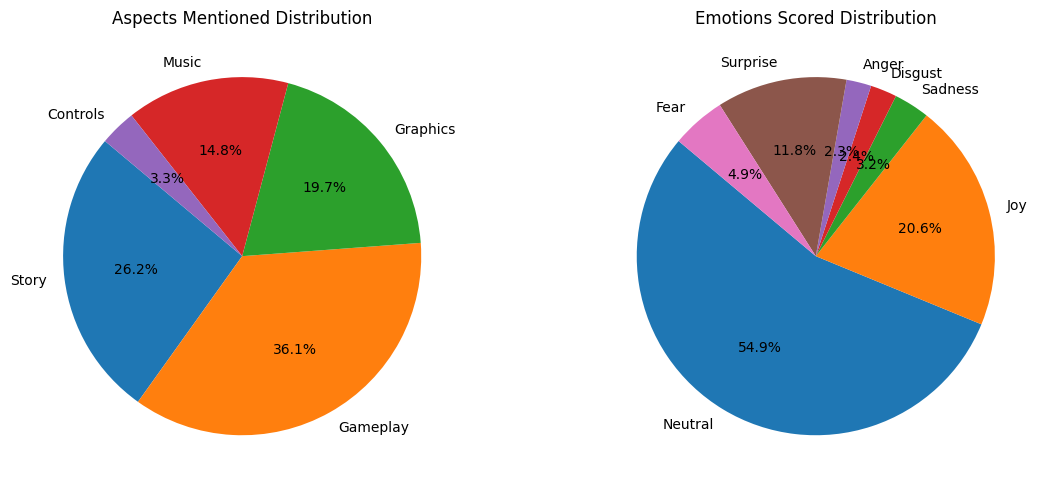

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(
    aspect_mention_tally.values(),
    labels=[k.title() for k in aspect_mention_tally.keys()],
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Aspects Mentioned Distribution")

plt.subplot(1, 2, 2)
plt.pie(
    emotion_tally.values(),
    labels=[k.title() for k in emotion_tally.keys()],
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Emotions Scored Distribution")

plt.tight_layout()
plt.show()

We will add the insights (minus the pie chart visualization) to a .csv file.

In [52]:
import csv
from collections import defaultdict

# Step 1: Define all aspect and emotion categories we want to include
aspect_fields = ['graphics', 'gameplay', 'story', 'music', 'controls', 'pacing']
all_emotion_labels = set()

# Step 2: Collect data for each review
review_data = []

for i, review in enumerate(all_reviews, start=1):
    review_row = {"ReviewID": i}

    # Aspect analysis
    aspects_result = aspect_sentiment_analysis(review)
    for asp in aspect_fields:
        review_row[asp] = len(aspects_result.get(asp, []))

    # Emotion detection
    emotions_result = detect_emotions(review)
    for label in emotions_result:
        all_emotion_labels.add(label)
        review_row[label] = round(emotions_result[label], 4)

    review_data.append(review_row)

# Step 3: Define final header (ensure all columns are present even if empty)
all_emotion_fields = sorted(list(all_emotion_labels))  # For consistency
header = ["ReviewID"] + aspect_fields + all_emotion_fields

# Step 4: Write to CSV
with open("TLoZ_OOT_review_analysis.csv", mode="w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()

    for row in review_data:
        # Fill in missing emotion fields with 0
        for field in header:
            if field not in row:
                row[field] = 0.0
        writer.writerow(row)


Lastly, we will read the csv file we created for the review data and combine it with our visualization in a .pdf file.

In [68]:
df = pd.read_csv("TLoZ_OOT_review_analysis.csv")

aspect_mention_tally = df[['graphics', 'gameplay', 'story', 'music', 'controls', 'pacing']].sum().to_dict()
emotion_cols = [col for col in df.columns if col not in ['ReviewID'] + list(aspect_mention_tally.keys())]
emotion_tally = df[emotion_cols].sum().to_dict()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Aspect Sentiment Pie Chart
axs[0].pie(
    aspect_mention_tally.values(),
    labels=[k.title() for k in aspect_mention_tally.keys()],
    autopct='%1.1f%%',
    startangle=140
)
axs[0].set_title("Aspects Mentioned Distribution")

# Emotions Detected Pie Chart
axs[1].pie(
    emotion_tally.values(),
    labels=[k.title() for k in emotion_tally.keys()],
    autopct='%1.1f%%',
    startangle=140
)
axs[1].set_title("Emotions Scored Distribution")

# Saving the figure
plt.tight_layout()
chart_path = "zelda_OOT_review_piecharts.png"
fig.savefig(chart_path, dpi=300)
plt.close()

# Set up the PDF file

doc = SimpleDocTemplate("zelda_OOT_review report.pdf", pagesize=landscape(letter))
styles = getSampleStyleSheet()
elements = []

elements.append(Paragraph("Zelda: Ocarina of Time Review Analysis Report", styles['Title']))
elements.append(Spacer(1, 12))
elements.append(Paragraph("This report summarizes critical review data for The Legend of Zelda: Ocarina of Time.  In it, aspects are scored from 0 to 1 in terms of presence in each review and emotion percentage is measured in each review with each emotion also receiving a score.", styles['BodyText']))
elements.append(Spacer(1, 12))

elements.append(Image(chart_path, width=480, height=220))
elements.append(Spacer(1, 12))

# Add the table of review data to the PDF

table_data = [df.columns.tolist()] + df.round(2).values.tolist()
table = Table(table_data, repeatRows=1)
table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('GRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold')
]))
elements.append(table)

# Generate the PDF

doc.build(elements)
print("PDF of report created.  Titled: zelda_OOT_review report.pdf.")

PDF of report created.  Titled: zelda_OOT_review report.pdf.
